# Importing the libraries

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

TensorFlow version: 2.9.2


# Initialize train and test dataset


making the grids

In [6]:
modinfo = np.loadtxt('modinfo.csv',dtype=float,delimiter=',')

In [7]:
allegrids = []
for ii in range(len(modinfo)):
  grid = np.zeros((200,200))
  for kk in range(np.int(np.round(modinfo[ii,0]))):
      for jj in range(200):
        grid[kk,jj] = modinfo[ii,2]

  for kk in range(np.int(np.round(modinfo[ii,0])),200):
    for jj in range(200):
      grid[kk,jj] = modinfo[ii,3]

  tanding = np.abs(np.round(np.tan(np.deg2rad(modinfo[ii,1])) * 200/2))
  for mm in range(100,200):
    for kk in range(max(0,np.int(-(mm-100)*tanding/100 + np.int(np.round(modinfo[ii,0])))),np.int(np.round(modinfo[ii,0]))):
      grid[kk,mm] =  modinfo[ii,3]

  for mm in range(0,100):
    for kk in range(np.int(np.round(modinfo[ii,0])),min(200,np.int(-(mm-100)*tanding/100 + np.int(np.round(modinfo[ii,0]))))):
      grid[kk,mm] =  modinfo[ii,2]
  allegrids.append(grid)
#reduce dimension (for minimal RAM usage)
herschaalmod = Sequential()
herschaalmod.add(MaxPooling2D(3, 3))
herschaalmod.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
X = np.array(allegrids).reshape(len(allegrids), 200,200,1)
kleinegrids = herschaalmod.predict(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

230/230 [==============================] - 6s 28ms/step


In [8]:
targetdata = np.loadtxt('verschilgeschaald.csv',dtype=float,delimiter=',') #data that we want to predict
dim_targetdata = 99 #number of values that need to be predicted per input point
grids = kleinegrids #input igures
dimgrids = 66 #dimensionality of the grids
train_size = 5000 #number of datapoints in the train dataset
test_size = 177 #number of datapoints in the test dataset
num_feature_maps = 9 #number of feature maps in the convolutional layer
kernel_size = 5 #dimension of the kernel (kernel_size x kernel_size)
dense_layer_size = 512 #number of units for the dense layer 

In [9]:
indexen = range(len(targetdata))
X_trainges, X_testges, indexen_trainges_final, indexen_testges_final = train_test_split(grids, indexen, train_size=train_size, test_size=test_size, random_state=333)
training_yges = targetdata[indexen_trainges_final]
y_testges = targetdata[indexen_testges_final]

In [10]:
X1 = np.array(X_trainges).reshape(len(X_trainges), dimgrids,dimgrids,1)
Y = np.array(training_yges).reshape(len(training_yges),1, dim_targetdata) 
#note that it is better to standardize the target data

# Making the model

In [11]:
models = Sequential()
models.add(Conv2D(num_feature_maps,kernel_size=kernel_size,activation='relu',input_shape=(dimgrids, dimgrids, 1)))
models.add(MaxPooling2D(2, 2))
models.add(Flatten())
models.add(Dense(dense_layer_size, activation='relu'))
models.add(Dropout(0.1))
models.add(tf.keras.layers.Reshape((1,dense_layer_size), input_shape=(dense_layer_size,))) #1 timestep en dense_layer_size features
models.add(tf.keras.layers.GRU(99,return_sequences=True))
models.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
models.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 9)         234       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8649)              0         
                                                                 
 dense (Dense)               (None, 512)               4428800   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                      

In [12]:
hists = models.fit(X1, Y, epochs=100,validation_split=0.2,batch_size=32)

Epoch 1/100
125/125 [==============================] - 17s 119ms/step - loss: 7.7443 - accuracy: 0.0355 - val_loss: 0.0187 - val_accuracy: 0.1120
Epoch 2/100
125/125 [==============================] - 17s 135ms/step - loss: 7.7337 - accuracy: 0.0382 - val_loss: 0.0135 - val_accuracy: 0.0220
Epoch 3/100
125/125 [==============================] - 19s 154ms/step - loss: 7.7226 - accuracy: 0.0410 - val_loss: 0.0111 - val_accuracy: 0.0510
Epoch 4/100
125/125 [==============================] - 22s 174ms/step - loss: 7.7168 - accuracy: 0.0420 - val_loss: 0.0105 - val_accuracy: 0.0520
Epoch 5/100
125/125 [==============================] - 15s 116ms/step - loss: 7.7136 - accuracy: 0.0518 - val_loss: 0.0093 - val_accuracy: 0.0910
Epoch 6/100
125/125 [==============================] - 14s 111ms/step - loss: 7.7136 - accuracy: 0.0580 - val_loss: 0.0086 - val_accuracy: 0.0670
Epoch 7/100
125/125 [==============================] - 15s 120ms/step - loss: 7.7119 - accuracy: 0.0770 - val_loss: 0.0080 -

final prediction

In [36]:
X_input = np.array(grids).reshape(len(grids), dimgrids,dimgrids,1)
predictie = models.predict(X_input)

230/230 [==============================] - 10s 43ms/step


Text(0.5, 0, 'Time')

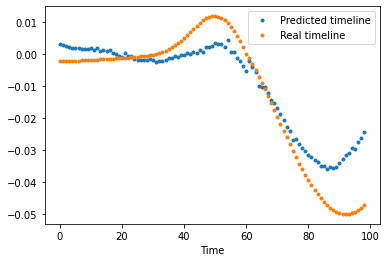

In [38]:
plt.plot(predictie[500][0],'.',label='Predicted timeline')
plt.plot(targetdata[500],'.',label='Real timeline')
plt.legend()
plt.xlabel('Time')

Text(0.5, 0, 'Depth')

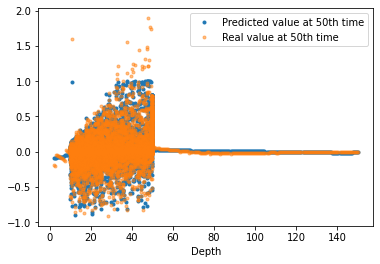

In [19]:
plt.plot(modinfo[:,0],predictie[:,0,50],'.',label='Predicted value at 50th time')
plt.plot(modinfo[:,0],targetdata[:,50],'.',alpha=0.5,label='Real value at 50th time')
plt.legend()
plt.xlabel('Depth')

## Logical RNN combination (just for information on how to create the structure of a logical RNN (with dense layer) in keras as it is not straightforward)

In [20]:
aantal_units = 2
params_input = keras.Input(shape=(dimgrids,dimgrids,1))
convlaag = Conv2D(num_feature_maps,kernel_size=kernel_size,activation='relu',input_shape=(dimgrids, dimgrids, 1))(params_input)
poollaag = MaxPooling2D(2, 2)(convlaag)
flatlaag = Flatten()(poollaag)
denselaag = Dense(dense_layer_size, activation='relu')(flatlaag)
reshlaag = tf.keras.layers.Reshape((1,dense_layer_size), input_shape=(dense_layer_size,))(denselaag)

inputGRUlist = []
for ii in range(dim_targetdata):
  inputGRUlist.append(reshlaag)
inputGRU = tf.keras.layers.concatenate(inputGRUlist,axis=1)
naRNN = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(aantal_units,input_shape=(dim_targetdata,dense_layer_size),return_sequences=True))(inputGRU)
ylist = tf.unstack(naRNN,num=dim_targetdata,axis=1)
ylistdense = []
for ii in range(0,dim_targetdata):
    yy = tf.keras.layers.Dense(1,activation='linear')(ylist[ii])
    ylistdense.append(yy)
conc = tf.keras.layers.concatenate(ylistdense)

model = keras.Model(inputs=params_input,outputs=conc)
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 66, 66, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 62, 62, 9)    234         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 31, 31, 9)   0           ['conv2d_1[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 8649)         0           ['max_pooling2d_3[0][0]']        
                                                                                              

In [21]:
hists = models.fit(X1, Y, epochs=100,validation_split=0.2,batch_size=32)

X_input = np.array(grids).reshape(len(grids), dimgrids,dimgrids,1)
predictie = models.predict(X_input)

Epoch 1/100
125/125 [==============================] - 15s 117ms/step - loss: 7.7060 - accuracy: 0.1558 - val_loss: 0.0061 - val_accuracy: 0.1650
Epoch 2/100
125/125 [==============================] - 14s 111ms/step - loss: 7.7060 - accuracy: 0.1602 - val_loss: 0.0057 - val_accuracy: 0.1900
Epoch 3/100
125/125 [==============================] - 15s 122ms/step - loss: 7.7059 - accuracy: 0.1660 - val_loss: 0.0068 - val_accuracy: 0.1710
Epoch 4/100
125/125 [==============================] - 15s 116ms/step - loss: 7.7059 - accuracy: 0.1615 - val_loss: 0.0067 - val_accuracy: 0.1800
Epoch 5/100
125/125 [==============================] - 14s 115ms/step - loss: 7.7058 - accuracy: 0.1600 - val_loss: 0.0063 - val_accuracy: 0.1840
Epoch 6/100
125/125 [==============================] - 15s 121ms/step - loss: 7.7059 - accuracy: 0.1625 - val_loss: 0.0058 - val_accuracy: 0.1700
Epoch 7/100
125/125 [==============================] - 14s 110ms/step - loss: 7.7058 - accuracy: 0.1580 - val_loss: 0.0065 -

In [25]:
X_input = np.array(grids).reshape(len(grids), dimgrids,dimgrids,1)
predictie = model.predict(X_input)

230/230 [==============================] - 15s 60ms/step


Text(0.5, 0, 'Time')

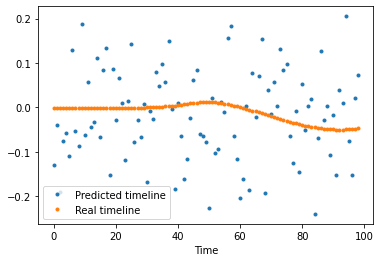

In [32]:
plt.plot(predictie[500],'.',label='Predicted timeline')
plt.plot(targetdata[500],'.',label='Real timeline')
plt.legend()
plt.xlabel('Time')

Text(0.5, 0, 'Depth')

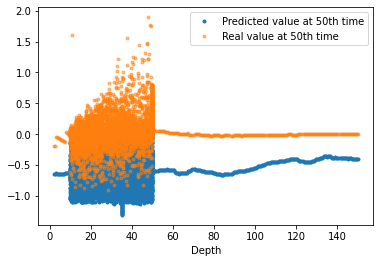

In [34]:
plt.plot(modinfo[:,0],predictie[:,50],'.',label='Predicted value at 50th time')
plt.plot(modinfo[:,0],targetdata[:,50],'.',alpha=0.5,label='Real value at 50th time')
plt.legend()
plt.xlabel('Depth')